In [1]:
import json
import os
import sys
import timeit

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error

sys.path.append(r"../")
from ct_assist import transform, estimator

# Testing for optimal iterations vs. execution time

In [2]:
results = []
results_time = []
begin = 2
end = 5
time_settings = np.logspace(begin,end,num=end-begin+1,base=10,dtype='int')

In [3]:
time_settings

array([   100,   1000,  10000, 100000])

In [4]:
image_coord_dict = dict()
image_coord_dict["00.jpg"] = np.array([[1470, 1430], [2333, 1355], [3247, 1781], [1935, 1952]])
image_coord_dict["01.jpg"] = np.array([[1495, 1552], [2219, 1589], [1843, 1969], [805, 1875]])
image_coord_dict["03.jpg"] = np.array([[1216, 1398], [2215, 1754], [3268, 1530], [2067, 1282]])   

def setup_vars():
    """Loads data for test_transform_image"""
    data_dir = r"./data/table"
    json_fp = os.path.join(data_dir, "anno.json")
    arr_fp = os.path.join(data_dir, "anno.npz")
    with open(json_fp, "r") as fp:
        mappings = json.load(fp)

    with np.load(arr_fp) as arrs:
        anno_dict = {img: {"heads": arrs[f"{prefix}heads"],
                           "feet": arrs[f"{prefix}feet"]}
                     for img, prefix in mappings.items()}
    
    for key, items in anno_dict.items():
        if key.endswith("02.jpg"):
            continue
        else:
            image_coords = image_coord_dict[key[-6:]]
        # feet and heads have been swapped in annotations
        reference = np.array([items["feet"], items["heads"]])
        height = 0.095  # m
        STD = 0.01  # m
        img = Image.open(key)
        yield (img, reference, height, STD, image_coords)
        
params = next(setup_vars())

Approximately linear increase 

In [5]:
number = 10

for setting in time_settings:
    func = lambda: results.append(estimator.area(transform.fit_transform(*params, iters=setting)[:,:2]))
    results_time.append(timeit.timeit(func, number=int(number)))
    print(f"{setting} iterations takes approx {results_time[-1] / number} seconds")

100 iterations takes approx 0.05526295999999999 seconds
1000 iterations takes approx 0.42929458 seconds
10000 iterations takes approx 4.42428849 seconds
100000 iterations takes approx 46.74610566 seconds


In [6]:
# convert to np.array
results_time = np.array(results_time)
results = np.array(results)

In [7]:
results_time / number

array([ 0.05526296,  0.42929458,  4.42428849, 46.74610566])

In [8]:
results

array([1.42820535, 1.81617055, 1.7464144 , 3.64371446, 1.87017567,
       2.3106457 , 1.73458589, 2.86760989, 2.30566619, 1.54672078,
       1.50875343, 2.04930412, 1.4273007 , 1.61181523, 1.36353118,
       1.35870173, 1.5500095 , 1.27506549, 1.29100466, 1.24388681,
       1.49094741, 1.43120371, 1.5310597 , 2.06904847, 1.58038377,
       1.33096672, 1.64752746, 1.32215532, 1.38349898, 1.48585374,
       1.39636865, 1.44072721, 1.4522215 , 1.46277493, 1.51199945,
       1.66403486, 1.47945191, 1.4402654 , 0.8985744 , 1.49380919])

In [9]:
y_true = np.repeat(1.33455, results.size)

In [10]:
RMSE = []
for i in range(0, number * time_settings.size, number):
    RMSE.append(mean_squared_error(y_true[:number], results[i:i+number], squared=False))
    print(RMSE[-1])
    
    
# mean_squared_error(y_true, results, squared=False)

1.0237501924359245
0.26233555249546087
0.2820905151184917
0.20809672265883958


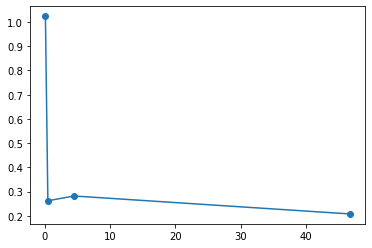

In [11]:
plt.scatter(results_time / number, RMSE)
plt.plot(results_time / number, RMSE)
plt.show()

For small scale experiments, 1e4 seems to be the optimal time-performance option. 